<a href="https://colab.research.google.com/github/llw522/IMLO-Coursework/blob/Collab_Uploads/train_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#Normalise Data

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_load = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_load = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck')

100%|██████████| 170M/170M [00:06<00:00, 26.9MB/s]


#Check Data Integrity

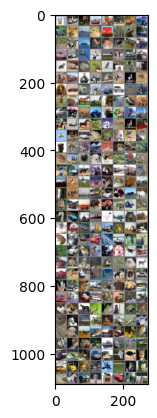

tensor([3, 1, 4, 8, 7, 4, 4, 9, 2, 5, 8, 3, 9, 6, 6, 1, 4, 2, 8, 4, 3, 2, 7, 9,
        1, 1, 0, 0, 0, 7, 1, 8, 3, 0, 6, 6, 2, 3, 2, 3, 7, 9, 9, 0, 2, 0, 7, 2,
        5, 9, 5, 0, 1, 1, 0, 0, 7, 3, 7, 0, 3, 5, 1, 6, 1, 9, 6, 1, 1, 3, 2, 9,
        7, 0, 7, 6, 8, 4, 7, 3, 2, 4, 1, 6, 6, 2, 5, 3, 2, 4, 6, 0, 5, 5, 4, 6,
        6, 8, 2, 5, 3, 4, 9, 2, 2, 0, 7, 9, 9, 9, 9, 2, 0, 2, 7, 4, 3, 3, 3, 9,
        7, 6, 8, 9, 1, 3, 0, 3, 6, 9, 1, 5, 1, 4, 0, 4, 2, 1, 8, 8, 2, 0, 3, 9,
        3, 5, 8, 8, 9, 6, 9, 8, 6, 3, 4, 9, 0, 8, 7, 4, 4, 1, 5, 0, 9, 5, 3, 9,
        9, 3, 9, 4, 6, 2, 5, 4, 9, 2, 1, 4, 2, 7, 5, 1, 5, 9, 5, 9, 3, 6, 9, 8,
        1, 5, 1, 8, 6, 9, 2, 0, 3, 2, 7, 6, 6, 3, 6, 6, 2, 7, 0, 7, 2, 0, 2, 8,
        6, 5, 7, 8, 9, 9, 4, 6, 5, 3, 6, 4, 8, 8, 3, 0, 9, 3, 4, 1, 8, 0, 2, 3,
        1, 1, 6, 4, 2, 4, 3, 3, 4, 7, 9, 2, 3, 1, 9, 7])
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
def imshow(image):
  image = image / 2 + 0.5
  npImage = image.numpy()
  plt.imshow(np.transpose(npImage, (1, 2, 0)))
  plt.show()

iterData = iter(train_load)
images, labels = next(iterData)

imshow(torchvision.utils.make_grid(images))
print(labels)
print(classes)

#Create Convolutional Network

In [5]:
class cifar_sort(nn.Module):
  def __init__(self):
    super().__init__()
    self.convert1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.convert2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.convert3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.linear1 = nn.Linear(4*4*64, 500)
    self.dropout = nn.Dropout(0.2)
    self.linear2 = nn.Linear(500, 10)

  def forward(self, x):
      x = F.relu(self.convert1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.convert2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.convert3(x))
      x = F.max_pool2d(x, 2, 2)

      x = x.view(-1, 4*4*64)
      x = F.relu(self.linear1(x))
      x = self.dropout(x)
      x = self.linear2(x)

      return x

#Establish Network on CPU

In [7]:
device = torch.device('cpu')
classifier = cifar_sort().to(device)

#Loss Function and Optimiser

In [8]:
lossFn = nn.CrossEntropyLoss()

optimiser = optim.Adam(classifier.parameters(), lr = 0.01)

#Monitored Training

In [11]:
epochs = 2
losses = []
successes = []
test_losses = []
test_successes = []
total_losses = []
total_successes = []
test_total_losses = []
test_total_successes = []


for i in range(epochs):
  losses = 0.0
  successes = 0.0
  test_losses = 0.0
  test_successes = 0.0

  for inputs, labels in train_load:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = classifier(inputs)
    loss = lossFn(outputs, labels)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    _, preds = torch.max(outputs, 1)
    losses += loss.item()
    successes += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_load:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)
      test_outputs = classifier(test_inputs)
      test_loss = lossFn(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_losses += loss.item()
      test_successes += torch.sum(test_preds == test_labels.data)

  epoch_loss = losses / (len(train_load)*batch_size)
  epoch_success = successes.float() / (len(train_load)*batch_size)
  total_losses.append(epoch_loss)
  total_successes.append(epoch_success.cpu().numpy())

  test_epoch_loss = test_losses / (len(test_load)*batch_size)
  test_epoch_success = test_successes.float() / (len(test_load)*batch_size)
  test_total_losses.append(test_epoch_loss)
  test_total_successes.append(test_epoch_success.cpu().numpy())

  print('epoch:', (i+1))
  print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_success.cpu().item()))
  print('test loss: {:.4f}, acc {:.4f} '.format(test_epoch_loss, test_epoch_success.cpu().item()))

epoch: 1
training loss: 0.0058, acc 0.4585 
test loss: 0.0051, acc 0.4689 
epoch: 2
training loss: 0.0055, acc 0.4876 
test loss: 0.0062, acc 0.4925 


#Training Results

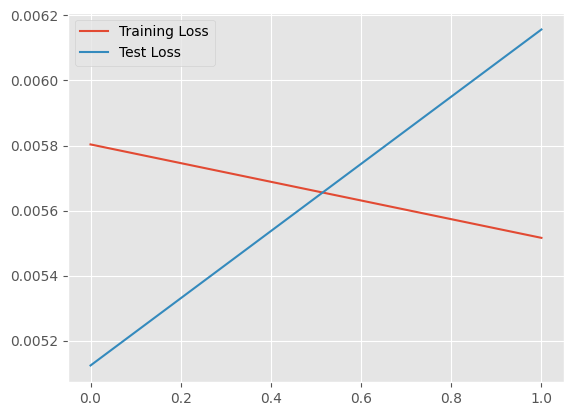

In [12]:
plt.style.use('ggplot')
plt.plot(total_losses, label='Training Loss')
plt.plot(test_total_losses, label='Test Loss')
plt.legend()

#Save Model

In [13]:
PATH = './cifar_classifier.pth'
torch.save(classifier.state_dict(), PATH)